# Epidemic Intelligence: data, models and machine learning in the age of Coronavirus

In this notebook we are going to introduce some **Machine Learning concepts** (ML from here on) using the trending topic of these days: coronavirus.
We have been following two articles from [Codemotion](https://www.codemotion.com/) so please, **all credit for them**. The articles I'm talking about are those:
1. [Epidemic Intelligence, part 1: data, models and machine learning in the age of Coronavirus](https://www.codemotion.com/magazine/dev-hub/machine-learning-dev/epidemic-intelligence-data-models-and-machine-learning-in-the-age-of-coronavirus/?smclient=13e84094-79b1-4c21-9470-f7eaf2ab4e5c&utm_source=salesmanago&utm_medium=email&utm_campaign=DEEP_LEARNING_CONF_Push_Broad_2)
2. [Epidemic Intelligence, part 2: data, models and machine learning in the age of Coronavirus](https://www.codemotion.com/magazine/dev-hub/machine-learning-dev/epidemic-intelligence-part-2-data-models-and-machine-learning-in-the-age-of-coronavirus/?smclient=13e84094-79b1-4c21-9470-f7eaf2ab4e5c&utm_source=salesmanago&utm_medium=email&utm_campaign=DEEP_LEARNING_CONF_Push_Broad_2)

## The data

**Let's start with the data**. As it is said in the article, we will use a simple repository, where CSV data are maintained by The New York Times, based on reports from state and local health agencies. We can get the data from its [repository](https://github.com/nytimes/covid-19-data) as follows:

In [4]:
from git import Repo
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from pandas import read_csv
from shutil import rmtree
from tempfile import mkdtemp
from scipy.optimize import fmin
from keras.models import Sequential
from keras.layers import Dense, LSTM


def get_data_from_repository(repository, file):
    temporal_directory = mkdtemp()
    Repo.clone_from(repository, temporal_directory, branch="master", depth=1)
    with open(join(temporal_directory, file)) as cf:
        DATA = read_csv(cf)
    try:
        rmtree(temporal_directory)
    except:
        pass
    return DATA


DATA = get_data_from_repository("https://github.com/nytimes/covid-19-data", "us-states.csv")

First of all, we can take a look at the data we have:

In [5]:
DATA.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


As you can see, we have *dates*, *states*, *fips*, *cases* and *deaths*. In our case, we are going to study how to predict the number of cases and deaths. We can get easy statistics about our dataset with a simple order:

In [6]:
DATA.describe()

,fips,cases,deaths
count,5349.000000,5349.000000,5349.000000
mean,31.621798,14833.934754,834.241914
std,18.483644,39547.414146,2897.871606
min,1.000000,1.000000,0.000000
25%,17.000000,208.000000,3.000000
50%,31.000000,2318.000000,64.000000
75%,46.000000,11989.000000,440.000000
max,78.000000,382879.000000,30183.000000


First of all, we have to clean our data so let's check if we have any conflictive value:

In [7]:
DATA.isnull().sum()

date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

In [8]:
DATA.isna().sum()

date      0
state     0
fips      0
cases     0
deaths    0
dtype: int64

Now we have seen our dataset looks fine, we have to decide how to proceed with our study. In the codemotion article they work with just a little part of the data which is the one **associated with the state of New York**. You can get this subset by this simple order:

In [9]:
DATA.loc[DATA.state == "New York", ["cases", "deaths"]]

,cases,deaths
246,1,0
261,1,0
276,2,0
293,11,0
313,22,0
...,...,...
5107,378924,29918
5162,379977,30011
5217,381019,30066
5272,382102,30123


However, we will study the evolution of cases and deaths in the **whole dataset**. To do this, we need to make some changes over our data. Then, **we are going to group our data by date, calculating the sum for cases and deaths**:

In [14]:
DATA = DATA.groupby(['date']).sum()
DATA = DATA.loc[:, ["cases", "deaths"]]

Currently, our data looks different:

In [16]:
DATA.head()

,cases,deaths
date,,
2020-01-21,1,0
2020-01-22,1,0
2020-01-23,1,0
2020-01-24,2,0
2020-01-25,3,0


After this analysis of our original dataset and process it a little bit, it's always a good idea to also visualize it:

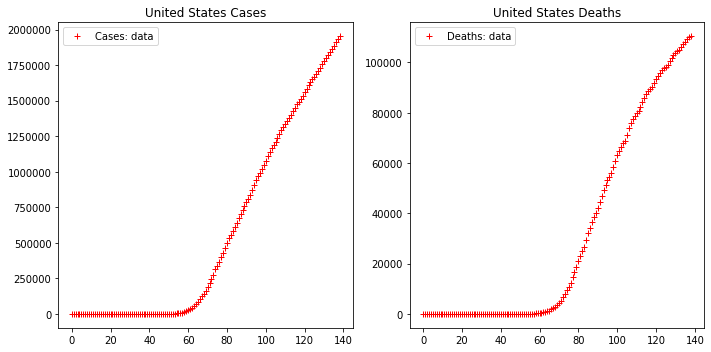

In [17]:
def plot_cases_and_deaths(cases, deaths):
    fig, axes = plt.subplots(1, 2, figsize=(10,5))
    axes[0].plot(cases, "r+", label="Cases: data")
    axes[1].plot(deaths, "r+", label="Deaths: data")
    axes[0].set_title("United States Cases")
    axes[1].set_title("United States Deaths")
    axes[0].legend()
    axes[1].legend()
    plt.tight_layout()


CASES = np.array(DATA.loc[:, "cases"])
DEATHS = np.array(DATA.loc[:, "deaths"])
plot_cases_and_deaths(CASES, DEATHS)

These two time series shows a trend which, as far as the series of cases is concerned, **starts increasing very rapidly from the 58th day on for cases and 60th day on for deaths**, so that curves increased after that date.

Once we have the data, how can we model such curves? Let us try some simple models such as **exponential model** and **logistic model** at first. I know, it's not the best option but we only want to introduce some concepts about how to fit a model.

## Parametric epidemic models

### Exponential modelling

Having in mind a law which given a time $t$ produces a value $C(t)$ for the cases at time $t$ and $D(t)$ for the deaths at time $t$, both being mathematical functions, **we can define the an exponential model with the form**: 
$$C(t) = c_{1}\exp(c_{2}t)$$
$$D(t) = d_{1}\exp(d_{2}t)$$
where $c_{1}$, $c_{2}$ and $d_{1}$, $d_{2}$ are "model parameters". As most of you can deduce now, we have an optimization problem in front of us. In fact, most Artificial Intelligence (AI from here on) problems, and each ML problem, are actually optimization problems.

**To find out the value of the parameters** which, substituted inside the functions, let them to approximate the real data in the best possible way, we may use an already programmed method to calibrate them. This calibration function just **minimizes the quadratic error since we use the Euclidean norm**:

Optimal parameters: [1.12906575 0.10776712]
Model error = 7095907.40
Optimal parameters: [3.44581771e-55 9.95014663e-01]
Model error = 580065.72


array([3.44581771e-55, 9.95014663e-01])

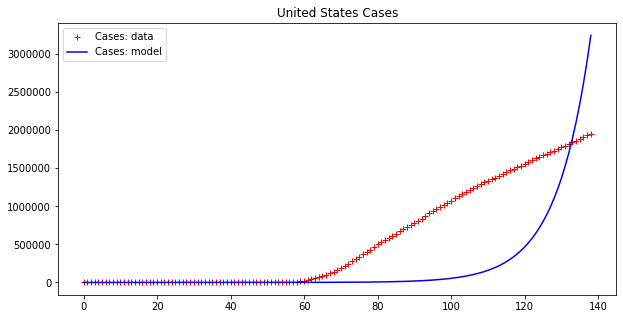

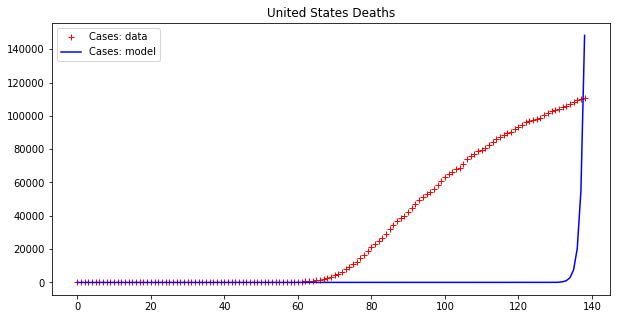

In [18]:
def exponential(t, params):
    return params[0] * np.exp(params[1] * t)


def apply_model(model, init_cond, interval, data, disp =True, shadow=False, title=""):
    opt_params = fmin(lambda p: np.linalg.norm(model(interval, p) - data),
                      init_cond, disp = False)
    if disp:
        y = model(interval, opt_params)
        err = np.linalg.norm(y - data)
        print("Optimal parameters:", opt_params)
        print(f"Model error = {err:.2f}")
        plt.figure(figsize=(10, 5))
        if shadow:
            plt.fill_between(interval, [0 if x < 0 else x for x in y - err], y+err, facecolor="silver")
        plt.plot(interval, data, "r+", label="Cases: data")
        plt.plot(interval, y, "b", label=f"Cases: model")
        plt.title(title)
        plt.legend()
    return opt_params


INTERVAL = np.arange(len(DATA))
apply_model(exponential, (CASES[0], 1),  INTERVAL, CASES,  title="United States Cases")
apply_model(exponential, (DEATHS[0], 1), INTERVAL, DEATHS, title="United States Deaths")

The first thing to look at when fitting some data are the errors and our errors are horrible. But indeed, as we have already pointed out, these data seem to display an exponential behavior only from the 58th day on or so in case of cases and 60th day for deaths. **We can get a better picture by cutting both time series dropping the initial values**:

Optimal parameters: [8.11644727e+04 2.40510789e-02]
Model error = 1639872.16
Optimal parameters: [4.00662178e+03 2.53601443e-02]
Model error = 114940.22


array([4.00662178e+03, 2.53601443e-02])

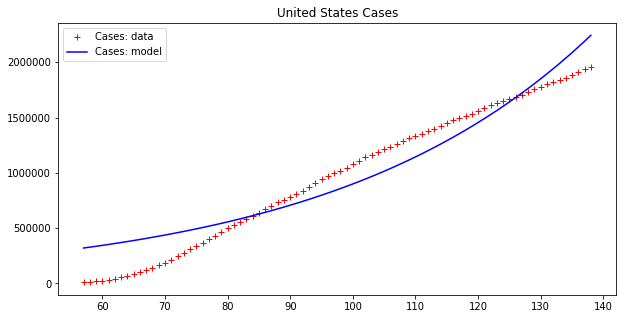

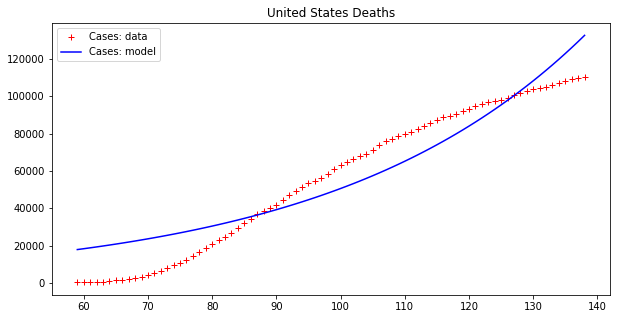

In [19]:
apply_model(exponential, (CASES[57], 1),  INTERVAL[57:], CASES[57:],  title="United States Cases")
apply_model(exponential, (DEATHS[59], 1), INTERVAL[59:], DEATHS[59:], title="United States Deaths")

These plots seem to display a much better fitting. However, on plotting just a line, we are in some sense cheating, since **our model fits data up to an error**. We should plot this "error area" as a strip around the curves:

Optimal parameters: [8.11644727e+04 2.40510789e-02]
Model error = 1639872.16
Optimal parameters: [4.00662178e+03 2.53601443e-02]
Model error = 114940.22


array([4.00662178e+03, 2.53601443e-02])

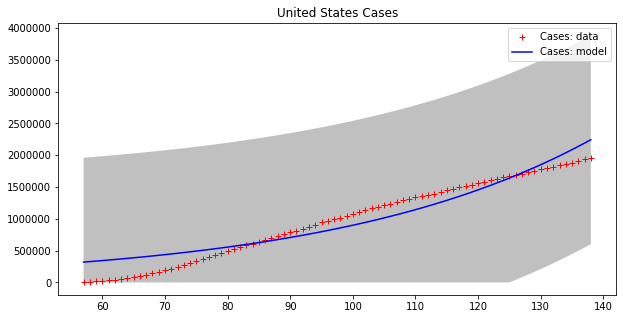

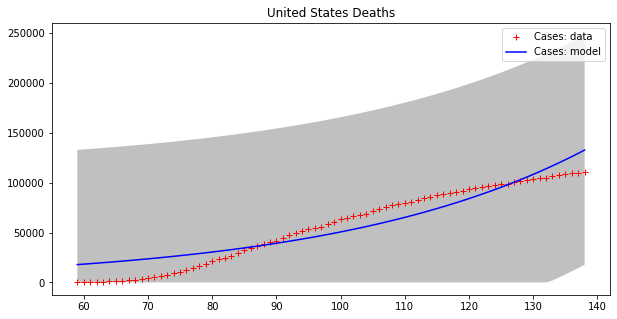

In [20]:
apply_model(exponential, (CASES[57], 1),  INTERVAL[57:], CASES[57:],  title="United States Cases",  shadow=True)
apply_model(exponential, (DEATHS[59], 1), INTERVAL[59:], DEATHS[59:], title="United States Deaths", shadow=True)

Now we can appreciate how coarse this modelling really is. **The worst thing about this "model" is it has a trend which makes no sense: it keeps increasing exponentially forever**. That would mean that both cases and deaths will continue to increase until they outnumber the total population on Earth.

Thus, this "model" is just a bad fit for some points on a curve and not a meaningful predictive model. **We can prove this by using splitting our data into two different sets, one for training purposes (80%) and the other to validate our model (the remaining 20%)**:

Model error = 8001524.315797689
Model error = 670919.814928478


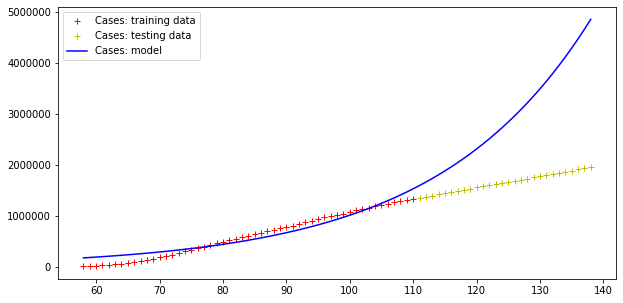

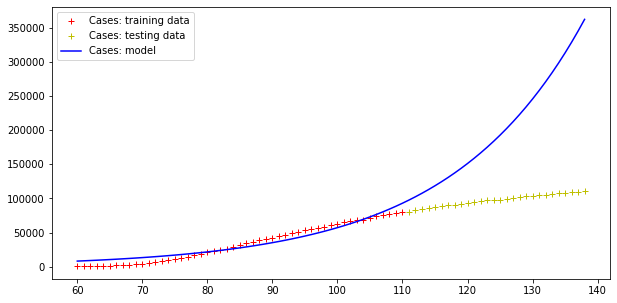

In [21]:
def train_exponential_model(interval, data, day_on):
    i0 = (len(interval) * 4) // 5
    opt_param = apply_model(exponential, (data[day_on-1], 1), interval[day_on-1:i0], data[day_on-1:i0], disp=False)
    y = exponential(interval[day_on:], opt_param)
    print("Model error =", np.linalg.norm(y - data[day_on:]))
    plt.figure(figsize=(10, 5))
    plt.plot(interval[day_on:i0], data[day_on:i0], "r+", label="Cases: training data")
    plt.plot(interval[i0:], data[i0:], "y+", label="Cases: testing data")
    plt.plot(interval[day_on:], y, "b", label="Cases: model")
    plt.legend()


train_exponential_model(INTERVAL, CASES,  58)
train_exponential_model(INTERVAL, DEATHS, 60)

Therefore: **this model fits the data (badly) but it is totally wrong at predictions**, as far the cases curve is concerned. Despite this, testing data are more or less fitted by this exponential curve.

Let's try to explain this, using easy maths. After all, we are interested in points $C_{0}$, $C_{1}$,… along a curve, not the entire curve $C(t)$: to recover the exponential curve, we remark that to produce a time series of exponential type the next point in the curve is the current one $C_{n}$ plus an increment proportional to $C_{n}$: the equation expressing this is

$$C_{n} + 1 − C_{n} = c_{2}C_{n}$$

We can use this definition to compute points of the curve $C$: in the case of exponential, this is unneeded, but it generalizes to other models, for example the logistic model.

### Logistic modelling

According to this model, the growth in a part of a population follows the law:

$$C_{n} + 1 – C_{n} = c_{2}C_{n}(N − C_{n})/N$$

being $N$ the total population. In this way $C_{n}$ will hit the $N$ value (in which case all the population is dead…) **instead of diverging as in the exponential series**. We can try to use this model to fit our data:

Optimal parameters: [1.94484499e+06 6.99045602e-02 9.73081480e+01]
Model error = 535218.01
Optimal parameters: [1.07956244e+05 8.78735354e-02 9.66127699e+01]
Model error = 27906.41


array([1.07956244e+05, 8.78735354e-02, 9.66127699e+01])

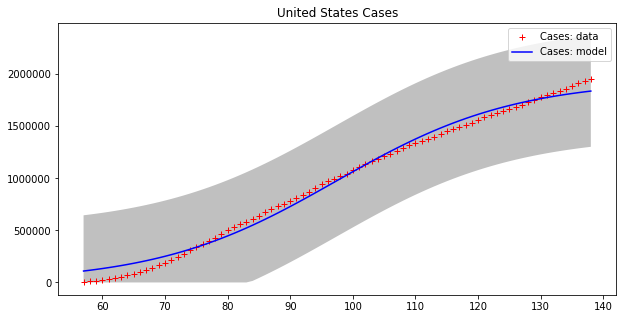

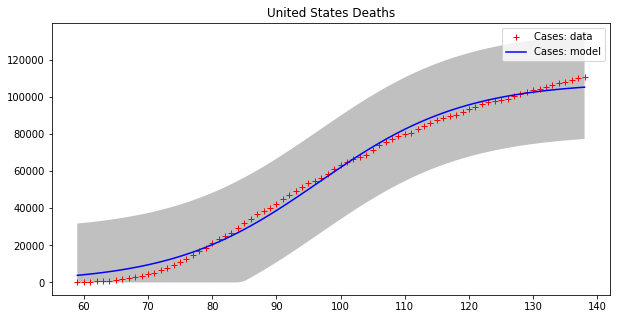

In [22]:
def logistic(t, params):
    return params[0] / (1 + np.exp(-params[1] * (t - params[2])))


apply_model(logistic, (2 * CASES[-1],  1, (INTERVAL[-1] - INTERVAL[57]) / 2), INTERVAL[57:], CASES[57:],  title="United States Cases",  shadow=True)
apply_model(logistic, (2 * DEATHS[-1], 1, (INTERVAL[-1] - INTERVAL[59]) / 2), INTERVAL[59:], DEATHS[59:], title="United States Deaths", shadow=True)

This model seems to fit better the curve of cases, even if the error is still large for cases, as the grey strips show. Furthermore, **we have to guess the population number, which is some kind of "hyper-parameter"** for our model. Let's split our data again:

Model error = 525546.3401936515
Model error = 27680.4546066321


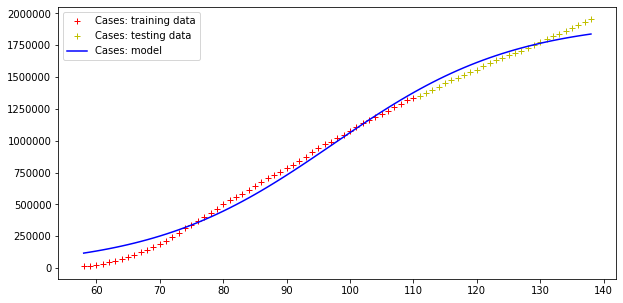

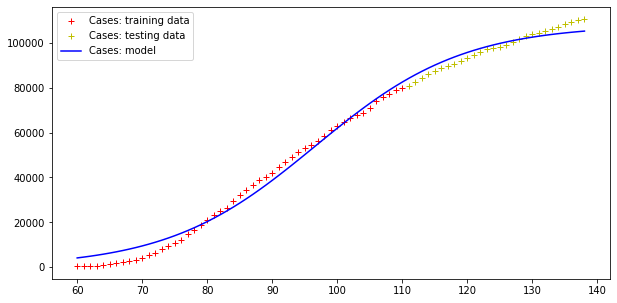

In [23]:
def train_logistic_model(interval, data, day_on):
    i0 = (len(interval) * 4) // 5
    opt_param = apply_model(logistic, (2 * data[-1],  1, (interval[-1] - interval[day_on-1]) / 2), interval[day_on-1:], data[day_on-1:],  disp=False)
    y = logistic(interval[day_on:], opt_param)
    print("Model error =", np.linalg.norm(y - data[day_on:]))
    plt.figure(figsize=(10, 5))
    plt.plot(interval[day_on:i0], data[day_on:i0], "r+", label="Cases: training data")
    plt.plot(interval[i0:], data[i0:], "y+", label="Cases: testing data")
    plt.plot(interval[day_on:], y, "b", label="Cases: model")
    plt.legend()


train_logistic_model(INTERVAL, CASES,  58)
train_logistic_model(INTERVAL, DEATHS, 60)

Errors remain huge, but the trend of the actual cases seems to be qualitatively like the model curve. In fact, these models are too simple to have any predictive value notwithstanding what is read on the Web.

Let's introduce the **SIR model** (which is the simplest one used in epidemiology). This model takes into account deaths and remove them from cases. Then, **the population is split into three parts: infected (I), dead (D) and all the rest (R)**, and the equations are not independent but related:

$$C_{n} + 1 = C_{n} + \frac{c_{2}C_{n}(N – C_{n} − D_{n})}{N} − d_{2}C_{n}$$
$$D_{n} + 1 = D_{n} + d_{2}C_{n}$$

**In a true SIR model we should model infected (I), dead or healed people (R, for retired), and people susceptible to be infected (S)**. However, these data are missing from our dataset. The idea of SIR is that during the virus spread population S decreases, while both I and R increases: I attains a maximum and start decreasing, while R keep increasing.

Error for D(t) = 2035881.9767661064
Error for D(t) = 129524.25399802152


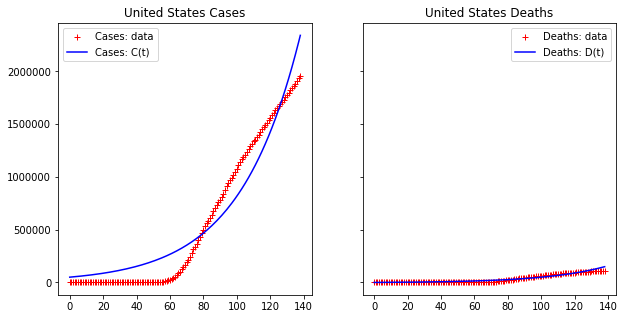

In [24]:
def IDR(t, c1, c2, d1, d2):
    if not isinstance(t, float) and not isinstance(t, int):
        return np.array([IDR(i, c1, c2, d1, d2) for i in t])
    if t == 0:
        return np.array([c1, d1])
    ft_1 = IDR(t - 1, c1, c2, d1, d2)
    ct_1 = ft_1[0]
    dt_1 = ft_1[1]
    return np.array([ct_1 + c2 * ct_1 * (N - ct_1 - dt_1)/N - d2 * ct_1, dt_1 + d2 * ct_1])


def calibration(interval, C, D):
    CD = np.array([[C[i], D[i]] for i in range(len(C))])
    return fmin(lambda params: np.linalg.norm(IDR(interval, params[0], params[1], params[2], params[3]) - CD), (C[0], 1, D[0], 1), disp = False)


def logistic_IDR(interval, cases, deaths, title_cases="", title_deaths=""):
    c1, c2, d1, d2 = calibration(interval, cases, deaths)
    fit = IDR(interval, c1, c2, d1, d2)
    print("Error for D(t) =", np.linalg.norm(fit[:len(interval), 0] - cases))
    print("Error for D(t) =", np.linalg.norm(fit[:len(interval), 1] - deaths))
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey='all')
    axes[0].plot(interval, cases, "r+", label="Cases: data")
    axes[1].plot(interval, deaths, "r+", label="Deaths: data")
    axes[0].plot(interval, fit[:, 0], "b", label=f"Cases: C(t)")
    axes[1].plot(interval, fit[:, 1], "b", label=f"Deaths: D(t)")
    axes[0].legend()
    axes[1].legend()
    axes[0].set_title(title_cases)
    axes[1].set_title(title_deaths)


N = 1e8
logistic_IDR(range(len(DATA)), CASES, DEATHS, "United States Cases", "United States Deaths")

Our model works better than the previous one but it is overstimating the increasing of cases and deaths.

To sum up, our models fit the data well but failed to predict it so... let's try something different: **non parametric models**.

## Non parametric models

Thus far, we limited ourselves to try to fit and predict data by using a known parametrized function with a fixed number of parameters. It is a **white-box model**. On the contrary, a non parametric model is just a **black box** which accepts a signal $x$ and emits another signal $y$ according to some inner rule which does depend on many parameters hidden in the model and whose interpretation is largely unknown. In these models we cannot modify its parameters, they're turned inside the black box. We just can control **"hyper-parameters"** which are external and whose tunning is totally empirical. **Artificial neural networks** belong to this family of models.

Considering neural networks as black boxes, we can look at them as algorithms. Then, we have an input vector which and the algorithm provide a single number (or another numeric vector) as output:

$$y = f(x_{1}, ..., x_{n})$$

Please notice this function needs to be built somehow dwelling upon a **training set**.

Each time the evaluation of a record of the training set fails, we changed the **hidden parameters** (called **weights**) to change the evaluation and try to reach the desired result. **The net "learns" the function**.

In our case, it will learn curve of cases and/or the curve of deaths. Indeed, **neural networks are great at interpolating functions, thus to fit known data and approximate unknown data**. We are not interested in the curve between today and yesterday, thus we are not interested in interpolating the curve but just in extrapolating from it. On **dealing with time series, time ordering is essential**.

A "traditional" **neural network is just a set of parallel layers**, which contains the network nodes (called neurons), which in turn contain network weights. Neurons are connected so that information passes from a layer through the next one by a rule called "backpropagation" (or its variants). Each time, the weights are changed and their previous values are discarded. So weights "have no memory".

Once we have introduced basic neural network concepts, we can start coding. We are using the same data as we did before, but let us show you this time in a different way:

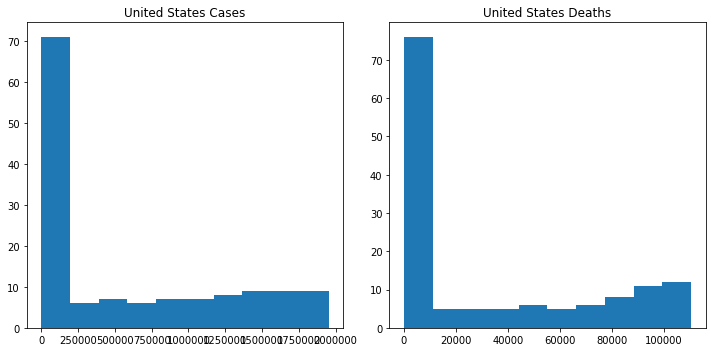

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist(CASES)
axes[1].hist(DEATHS)
axes[0].set_title("United States Cases")
axes[1].set_title("United States Deaths")
plt.tight_layout()

As we discussed before **we need a training set**, but at the moment we just have a time series $s_{0},..., s_{n}$ being $s_{i}$ numbers detected at times $i = 0, 2,..., N$. Assuming the next value depends only on the previous one (Markov hypothesis) then the prediction of $s_{i+1}$ is a function $s_{i}$, so that we want to learn the function $y = f(x)$ such that $s_{i+1} = f(s_{i})$ for $i = 0,...,N−1$. Then, our training data should set up as $(s_{1}, s_{0}), (s_{2}, s_{1}),...,(s_{N}, s_{N−1})$:

In [26]:
def extract_sample(series):
    X = []
    Y = []
    for i in range(len(series)-1):
        X.append(series[i:i+1])
        Y.append(series[i+1])
    return X, Y


INPUT_CASES,  OUTPUT_CASES  = extract_sample(CASES)
INPUT_DEATHS, OUTPUT_DEATHS = extract_sample(DEATHS)

Now we have a training set, but we still need a model. We’ll use a classical model, the so-called **LSTM** (Long-Short Term Model) which is available in the **Keras Python library**. Let’s start with the **one-layer LSTM**, the simplest case. We **design the model using Keras API**, which is more or less straightforward, setting some external parameters to standard values and setting hyper-parameters by some trial & error:

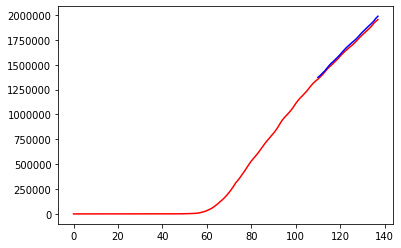

Loss = 525422002.24888384


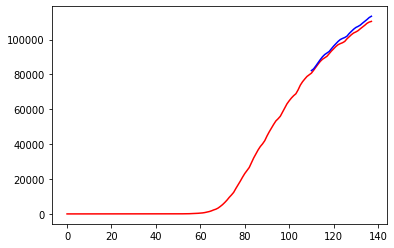

Loss = 3711065.307144165


In [27]:
def train_test(neural_network, X, Y, epochs=5000, training_percent_size = 0.8):
    N = len(X)
    n_training = int(N * training_percent_size)
    X_TRAINING, Y_TRAINING = np.array(X[:n_training]), np.array(Y[:n_training])
    X_TESTING, Y_TESTING = np.array(X[n_training:]), np.array(Y[n_training:])
    X_TRAINING = X_TRAINING.reshape((X_TRAINING.shape[0], X_TRAINING.shape[1], 1))
    X_TESTING = X_TESTING.reshape((X_TESTING.shape[0], X_TESTING.shape[1], 1))
    for i in range(epochs):
        neural_network.fit(X_TRAINING, Y_TRAINING, epochs=1, verbose=0, shuffle=False)
        neural_network.reset_states()
    Y_PREDICTED = []
    for x in X_TESTING:
        x = x.reshape((1, 1, 1))
        y = neural_network.predict(x, verbose=0)
        Y_PREDICTED.append(y[0][0])
    plt.plot(Y, 'r')
    plt.plot(range(n_training, N), Y_PREDICTED, 'b')
    plt.show()
    print("Loss =", np.linalg.norm(Y_TESTING - np.array(Y_PREDICTED))**2/len(Y_TESTING))
    return np.concatenate((Y_TRAINING, Y_PREDICTED))


nn = Sequential()
nn.add(LSTM(10, activation="relu", input_shape=(1, 1)))
nn.add(Dense(1))
nn.compile(loss="mean_squared_error", optimizer="adam")

prediction = train_test(nn, INPUT_CASES,  OUTPUT_CASES)
prediction = train_test(nn, INPUT_DEATHS, OUTPUT_DEATHS)

The model seems to get the trend of the curves, but take a look at the loss, it's not a good sign. We can try to **add one more layer**:

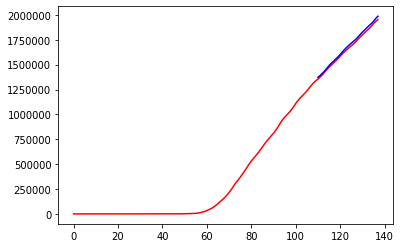

Loss = 515780225.25223213


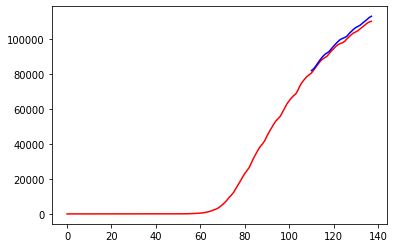

Loss = 3568888.132816859


In [28]:
nn2 = Sequential()
nn2.add(LSTM(10, activation="relu", input_shape=(1, 1), return_sequences=True))
nn2.add(LSTM(10, activation="relu"))
nn2.add(Dense(1))
nn2.compile(loss="mean_squared_error", optimizer="adam")

prediction = train_test(nn2, INPUT_CASES,  OUTPUT_CASES)
prediction = train_test(nn2, INPUT_DEATHS, OUTPUT_DEATHS)

Actually, inserting a new layer didn’t result in any significant improvement.

### A bit of time series lore

Let's try a different approach. Indeed, people used for time series fitting have surely become outraged by the poor pre-processing we did. **Time series are effectively studied when they are paths of stationary processes, which are solutions of stochastic dynamical systems whose behavior maintains, roughly speaking, mean and variance** within a certain range. In our data, the trend of the curve clearly depends on time, there is no iterative structure at a first sight.

Then, we may transform a series into a stationary one, so that the transformation is invertible. The simplest way to do that is to look at the series of differences of the given series $s_{0}, s_{1},\dots,s_{N}$, thus

$$d_{1} = s_{1} - s_{0}, d_{2} = s_{2} − s_{1},\dots, d_{N} = s_{N} - s_{N-1}$$

In both cases, the transformation $(s_{1},\dots, s_{N}) \rightarrow (d_{1},\dots, d_{N})$ is invertible (notice that we excluded $s_{0}$ from the original series, it is a sort of "initial condition" we keep aside), and the inverse is given by the recursive relations:

$$s_{1} = s_{0} + d_{1}, s_{2} = s_{1} + d_{2},\dots, s_{N} = s_{N-1} + d_{N}$$

In some sense the original series is the cumulative series of the differences one. Of course we could also define a different series with a given step $k$:

$$d_{k} = s_{k} - s_{0}, d_{k+1} = s_{k+1} - s_{1},\dots, d_{N} = s_{N} - s_{N-k}$$

Let us try, with step $k=1$, for our two coronavirus series:

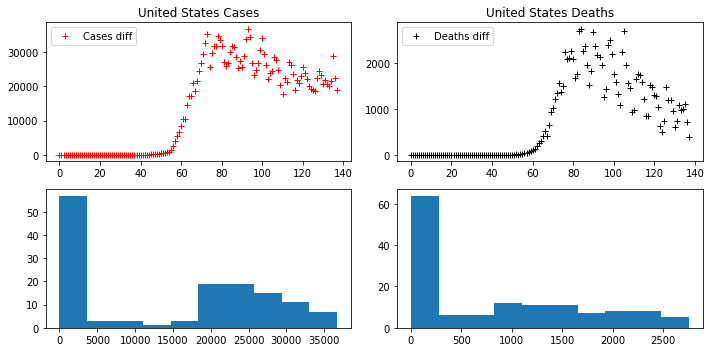

In [29]:
def difference(s):
    return [s[i + 1] - s[i] for i in range(len(s) - 1)]


def cumulated(s0, d):
    s = [s0]
    for i in range(len(d)):
        s.append(s[i] + d[i])
    return s


def plot_differences(cases, deaths):
    fig, axes = plt.subplots(2, 2, figsize=(10, 5))
    axes[0, 0].plot(cases,  "r+", label="Cases diff")
    axes[0, 1].plot(deaths, "k+", label="Deaths diff")
    axes[0, 0].legend()
    axes[0, 1].legend()
    axes[0, 0].set_title("United States Cases")
    axes[0, 1].set_title("United States Deaths")
    axes[1, 0].hist(cases)
    axes[1, 1].hist(deaths)
    plt.tight_layout()


D_CASES  = difference(CASES)
D_DEATHS = difference(DEATHS)
plot_differences(D_CASES, D_DEATHS)

**Differentiation may be iterated**, thus we may consider the second difference of a series (the difference of its difference series), and so on, and at each step the series become more and more similar to a stationary one. Of course, the k-th difference of a given series has $k$ elements less than the original one. Let's try with the third difference:

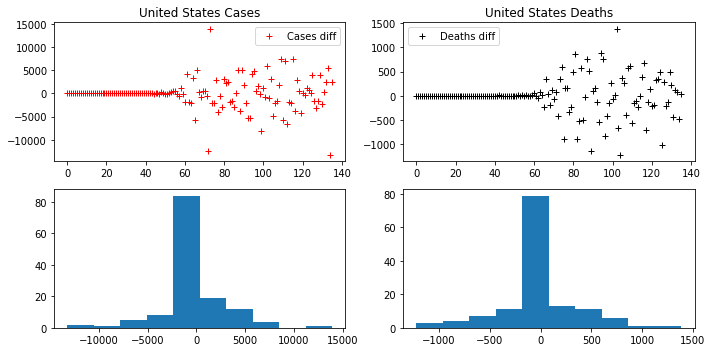

In [30]:
D3_CASES  = difference(difference(difference(CASES)))
D3_DEATHS = difference(difference(difference(DEATHS)))

plot_differences(D3_CASES, D3_DEATHS)

Notice that histograms tend to become more and more similar to **normal distributions**.

Let us perform again the **training of the neural network on different data**, and convert back the results into cumulated form:

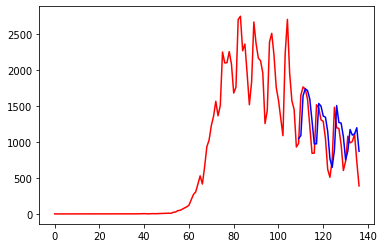

Loss = 100017.55423005379
Loss = 315182.78134281945


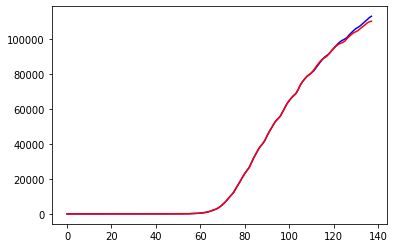

In [31]:
plt.figure(0)
D_INPUT_DEATHS, D_OUTPUT_DEATHS = extract_sample(D_DEATHS)
d_prediction = train_test(nn2, D_INPUT_DEATHS, D_OUTPUT_DEATHS)

plt.figure(1)
prediction = cumulated(OUTPUT_DEATHS[0], d_prediction)
plt.plot(prediction, 'b')
plt.plot(OUTPUT_DEATHS, 'r')
print("Loss =", np.linalg.norm(OUTPUT_DEATHS - np.array(prediction))**2/len(OUTPUT_DEATHS))

The performance has an impressive improvement.

Another invertible transformation which makes sense to apply in our case is the **scaling transformation**, by means of which we reduce our data inside a fixed interval. When using neural networks this is worth since such networks have nodes which usually output numbers between -1 and 1, unless otherwise stated.

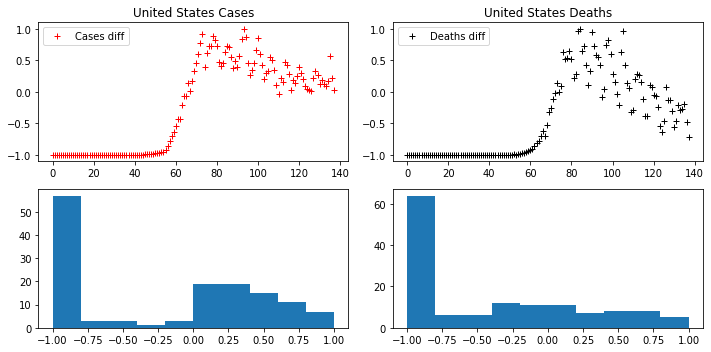

In [32]:
def scaling(s, a=-1, b=1):
    m = min(s)
    M = max(s)
    scale = (b - a)/(M - m)
    return a + scale * (s - m)


DS_CASES  = scaling(difference(CASES))
DS_DEATHS = scaling(difference(DEATHS))

plot_differences(DS_CASES, DS_DEATHS)

Finally, let us check our basic LSTM network to these data, and transform back the results to provide a prediction as we did before. We use the same parameters to train the network, but we let the activation function be the default one, which is a sigmoid function between -1 and 1.

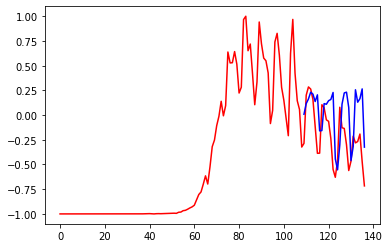

Loss = 0.13639291147252677
Loss = 3436892.880050214


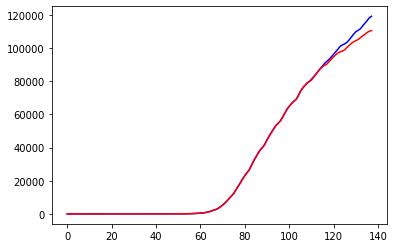

In [33]:
nn3 = Sequential()
nn3.add(LSTM(10, input_shape=(1, 1), return_sequences=True))
nn3.add(LSTM(10))
nn3.add(Dense(1))
nn3.compile(loss="mean_squared_error", optimizer="adam")

plt.figure(0)
DS_INPUT_DEATHS, DS_OUTPUT_DEATHS = extract_sample(DS_DEATHS)
ds_prediction = train_test(nn3, DS_INPUT_DEATHS, DS_OUTPUT_DEATHS)

plt.figure(1)
d_prediction = scaling(ds_prediction, min(D_DEATHS), max(D_DEATHS))
prediction = cumulated(OUTPUT_DEATHS[0], d_prediction)
plt.plot(prediction, 'b')
plt.plot(OUTPUT_DEATHS, 'r')
print("Loss =", np.linalg.norm(OUTPUT_DEATHS - np.array(prediction))**2/len(OUTPUT_DEATHS))

After all, have we learned some useful lessons:

1. Simple models **may fit** available data but are **not reliable to predict** anything.

2. To train a "parametric model" is easy and it is a **simple form of machine learning**: the difference with more advanced techniques is that here we pretend that the model follows a **deterministic rule**.

3. To show how **data preparation is a non trivial task** when facing machine learning algorithm implementation. Indeed, most of the code we wrote was due to data handling, while the model was set up in a handful of API calls.

4. To point out that barely making a **more complicated neural network does not imply a corresponding gaining in performance**. Even if it is very easy to complicate the model in Keras, do it only if actually needed.

Thanks all for taking a look at this simply notebook, but as I said before, all credit for Codemotion guys. If you are interested in these topics, do not miss the opportunity to attend their [Deep Learning online conference](https://events.codemotion.com/conferences/online/2020/deep-learning/?utm_source=magazine_5&utm_medium=CTA&utm_campaign=deep_learning).